In [54]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics

data = pd.read_csv('data/googleplaystore.csv')
data = data.dropna()
data = data.reset_index(drop=True)
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9360 entries, 0 to 9359
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 950.8+ KB


In [55]:
#Transformacion y limpieza del tamaño de instalacion
def sizes_trans(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None
    
data["Size"] = data["Size"].map(sizes_trans)

#Rellenando los vacios
data.Size.fillna(method = 'ffill', inplace = True)

#Transformacion del número de descargas(Installs)
def installs_trans(inst):
    try:
        x = (inst[:-1].replace(",",""))
        x = int(x)
        #return x
    except ValueError:
        print("Line is corrupt!", x)
        x = 0
    return np.log10(x)


data["Installs"] = data["Installs"].map(installs_trans)

#Transformacion del Tipo de app(Free/No Free) a binario
def type_trans(types):
    if types == 'Free':
        return 0
    else:
        return 1
    
data["Type"] = data["Type"].map(type_trans)

#Transformacion de los precios a int
def price_trans(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        if price == "veryone":
            price = 0
        price = float(price)
        return price
    
data["Price"] = data["Price"].map(price_trans).astype(float)

#Transformacion de las reviews a float

def review_trans(rev):
    if 'M' in rev:
        x = rev[:-1]
        x = float(x)*1000000
        return(np.log10(x))
    elif 'k' == rev[-1:]:
        x = rev[:-1]
        x = float(x)*1000
        return(np.log10(x))
    else:
        return (np.log10(float(rev)))

data["Reviews"] = data["Reviews"].map(review_trans).astype(float)

#Eliminando los parametros que no utilizaremos ya que no son relevantes
data.drop(labels = ["Last Updated","Current Ver", 'Android Ver', 'App'], axis = 1, inplace = True)

In [56]:
def rating_bynary_trans(rate):
    if rate < 4.5:
        return 0
    else:
        return 1

data["High_Rated"] = data["Rating"].map(rating_bynary_trans)

data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,High_Rated
0,ART_AND_DESIGN,4.1,2.201397,19000000.0,4.00000,0,0.0,Everyone,Art & Design,0
1,ART_AND_DESIGN,3.9,2.985426,14000000.0,5.69897,0,0.0,Everyone,Art & Design;Pretend Play,0
2,ART_AND_DESIGN,4.7,4.942058,8700000.0,6.69897,0,0.0,Everyone,Art & Design,1
3,ART_AND_DESIGN,4.5,5.333737,25000000.0,7.69897,0,0.0,Teen,Art & Design,1
4,ART_AND_DESIGN,4.3,2.985426,2800000.0,5.00000,0,0.0,Everyone,Art & Design;Creativity,0


In [57]:
from scipy.optimize import fmin_tnc as tnc
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures as pf
import sys

learning_rate = 1.0
POLY = 3

def poli_f(X, grado):
    poly = pf(grado)
    return poly, poly.fit_transform(X)

def J(theta, X, Y):
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    theta = np.reshape(theta, (1, n))
    v1 = np.dot(np.transpose((np.log(g(np.dot(X, np.transpose(theta)))))), Y)
    v2 = np.dot(np.transpose((np.log(1 - g(np.dot(X, np.transpose(theta)))))), (1 - Y))
    v3 = (learning_rate/(2*m)) * np.sum(theta[1:]**2)
    return (((-1/m)*(v1 + v2)) + v3)

def gradient(theta, X, Y):
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    theta = np.reshape(theta, (1, n))
    var1 = np.transpose(X)
    var2  = g(np.dot(X, np.transpose(theta)))-Y
    
    theta = np.c_[[0], theta[:, 1:]]
    var3 = (learning_rate/m) * theta
    return ((1/m) * np.dot(var1, var2)) + np.transpose(var3)

def g(z):
    """
    1/ 1 + e ^ (-0^T * x)
    """
    return 1/(1 + np.exp(-z))

def draw_data(X, Y):
    pos = np.where(Y == 0)[0] #vector with index of the Y = 1
    plt.scatter(X[pos, 0], X[pos, 1], marker='.', c='r')
    pos = np.where(Y == 1)[0].ravel() #vector with index of the Y = 1
    plt.scatter(X[pos, 0], X[pos, 1], marker='.', c='y')

def draw_decision_boundary(theta, X, Y, poly):
    x0_min, x0_max = X[:,0].min(), X[:,0].max()
    x1_min, x1_max = X[:,1].min(), X[:,1].max()
    xx1, xx2 = np.meshgrid(np.linspace(x0_min, x0_max), np.linspace(x1_min, x1_max))
    
    sigm = g(poly.fit_transform(np.c_[ xx1.ravel(), xx2.ravel()]).dot(theta))
    sigm = sigm.reshape(xx1.shape)

    plt.contour(xx1, xx2, sigm, [0.5], linewidths = 1, colors = 'g')

def draw(theta, X, Y, poly):
    plt.figure(figsize=(12,7))
    draw_data(X, Y)
    draw_decision_boundary(theta, X, Y, poly)
    plt.show()

def load_csv_svm(file_name, features):
    dataFile = pd.read_csv(file_name, header = 0)
    
    dataFile = dataFile.fillna(0)
    y = dataFile['Rating'].array
    
    X = np.array([])
    X = np.reshape(X, (len(y), 0))
    for i in range(len(features)):
        X = np.c_[X, dataFile[features[i]].array]
        
    return X, y

def load_Data(data, y_feat, features):
    #if y_feat == "Rating":
    #    data[y_feat] = data[y_feat].map(rating_bynary_trans)
    
    y = data[y_feat].array
    
    X = np.array([])
    X = np.reshape(X, (len(y), 0))
    for i in range(len(features)):
        X = np.c_[X, data[features[i]].array]
    return X, y

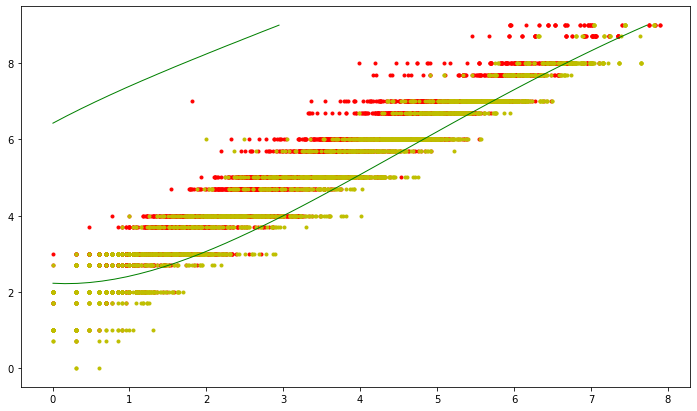

In [58]:
#X, y = load_csv_svm("data/googleplaystore.csv", ["Reviews", "Installs"])

X, y = load_Data(data, "High_Rated", ["Reviews", "Installs"])

X = np.array(X)
y = np.array(y)
y = np.reshape(y, (np.shape(y)[0], 1))

poly, X_poly = poli_f(X, POLY)
theta = np.zeros([1, np.shape(X_poly)[1]], dtype=float)

theta = tnc(func=J, x0=theta, fprime=gradient, args=(X_poly,y))[0]


draw(theta, X, y, poly)

In [59]:
class Normalization:
    """
    Regression Normalization (adding the one columns)
    """
    
    @staticmethod
    def n_data_matrix(X):
        """
        Normalize the given matrix using the mean and deviation of every column (attribute).
        Returns the normalized matrix, the mu vector (mean of every attribute) and sigma vector (deviation of every attributes).
        """
        n = np.shape(X)[1]
        X_norm = np.empty_like(X)
        sigma = np.empty(n)
        mu = np.empty(n)

        for i in range(0, n):
            mu[i] = np.mean(X[:, i]) #mean of every column or attribute
            sigma[i] = np.std(X[:, i]) #deviation of every column or attribute

            new_value = (X[:, i] - mu[i])/sigma[i] #normalize
            X_norm[:, i] = new_value

        mu = np.reshape(mu, (1, np.shape(mu)[0]))
        sigma = np.reshape(sigma, (1, np.shape(sigma)[0]))

        return X_norm, mu, sigma

    @staticmethod
    def n(X, mu, sigma):
        """
        Normalize a matrix using mu and sigma vectors obtained in a
        previous normalization 
        """
        aux1 = X[:, :] - mu[0, :]
        return aux1[:, :] / sigma[0, :]

    @staticmethod
    def n_single_attributes(attributes, mu, sigma):
        """
        Normalize a single set of different attributes using mu and sigma vectors obtained in a
        previous normalization 
        """
        new_data = (attributes - mu[:])/sigma[:] #normalize
        return new_data

In [60]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

NUM_TRIES = 1
feature1 = "Installs"
feature2 = "Reviews"
feature3 = "Price"

def draw_decisition_boundary(X, y, svm, true_score, mu, sigma, c, s):
    """
    valid for two feature
    """
    #calculating the graphic
    figure, ax = plt.subplots()
    x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x1, x2 = np.meshgrid(x1, x2)
    yp = svm.predict(np.array([x1.ravel(),x2.ravel()]).T).reshape(x1.shape)
    pos = (y == 1).ravel()
    neg = (y == 0).ravel()
    plt.scatter(X[pos, 0], X[pos, 1], color='blue', marker='o', label = "High rated")
    plt.scatter(X[neg, 0], X[neg, 1], color='black', marker='x', label = "Low rated")
    plt.contour(x1, x2, yp, colors=['red', 'purple'])

    #formatting the graphic with some labels
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.suptitle(("Score: " + str(float("{0:.3f}".format(true_score))) + "\n C: " + str(c) + "\n Sigma: " + str(s)))
    figure.legend()

    #set the labels to non-normalized values
    figure.canvas.draw()
    labels = [item for item in plt.xticks()[0]]
    for i in range(len(labels)):
        labels[i] = int(round((labels[i] * sigma[0, 0]) + mu[0, 0], -1))
    ax.xaxis.set_ticklabels(labels)

    labels = [item for item in plt.yticks()[0]]
    for i in range(len(labels)):
        labels[i] = int(round((labels[i] * sigma[0, 1]) + mu[0, 1], -1))
    ax.yaxis.set_ticklabels(labels)

    #show
    plt.show()

def draw_3D(X, y, svm, true_score, mu, sigma):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    pos = (y == 1).ravel()
    neg = (y == 0).ravel()
    ax.scatter(X[pos, 0], X[pos, 1], X[pos, 2], color='blue', marker='o', label = "Pay to Play")
    ax.scatter(X[neg, 0], X[neg, 1], X[neg, 2], color='red', marker='x', label = "Non Pay")
    plt.suptitle(("Score: " + str(true_score)))
    fig.legend()

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    
    plt.show()

def kernel_lineal(X, y, mu, sigma):
    svm = SVC(kernel='linear', C=1.0)
    svm.fit(X, y.ravel())
    score = true_score(X, y, svm)

    return svm

def kernel_gaussiano(X, y, mu, sigma):
    sigma = 0.1

    svm = SVC(kernel = 'rbf' , C= 1, gamma= (1 / ( 2 * sigma ** 2)) )
    svm.fit(X, y.ravel())
    score = true_score(X, y, svm)

    draw_decisition_boundary(X, y, svm, score, mu, sigma, 1, sigma)

    return svm

def true_score(X, y, svm):
    predicted_y = svm.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, predicted_y).ravel()
    score = 0
    if tp != 0:
        precision_score = tp / (tp + fp)
        recall_score = tp / (tp + fn)
        score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
    return score

def eleccion_parametros_C_y_Sigma(X, y, Xval, yval, mu, sigma):
    possible_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    C_value, sigma = 0, 0
    max_score = 0
    best_svm = None
    selected_C = 0
    selected_Sigma = 0

    for i in range(len(possible_values)):
        C_value = possible_values[i]
        for j in range(len(possible_values)):
            sigma = possible_values[j]
            svm = SVC(kernel = 'rbf' , C = C_value, gamma= (1 / ( 2 * sigma ** 2)))
            #-----------------------------------
            #print(y)
            svm.fit(X, y.ravel())
            current_score = true_score(Xval, yval, svm) #calcula el score con los ejemplos de validacion (mayor score, mejor es el svm)
            if current_score > max_score:
                max_score = current_score
                best_svm = svm
                selected_C = C_value
                selected_Sigma = sigma
    
    return best_svm, selected_C, selected_Sigma

#-----------------
def shuffle(a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)

        return a, b

def divide_rate_groups(X, y):
        X = np.array(X)
        y = np.array(y)
        y = np.reshape(y, (np.shape(y)[0], 1))

        X, y =shuffle(X, y)
        # ----------------------------------------------------------------------------------------------------
        legendPos = np.where(y == 1)
        legendX = X[legendPos[0]]
        legendY = y[legendPos[0]]

        normiePos = np.where(y == 0)
        normieX = X[normiePos[0]]
        normieY = y[normiePos[0]]
        # ----------------------------------------------------------------------------------------------------
        # TRAINIG GROUP
        normTrain = int(np.shape(normieX)[0]/4)
        trainX = normieX[:normTrain]
        trainY= normieY[:normTrain]

        legendTrain = int(np.shape(legendX)[0]/2)
        trainX = np.concatenate((trainX, legendX[:legendTrain]))
        trainY = np.concatenate((trainY, legendY[:legendTrain]))
        trainX, trainY = shuffle(trainX, trainY)
        # ----------------------------------------------------------------------------------------------------
        # VALIDATION GROUP
        normValid = int(np.shape(normieX)[0]/2)
        validationX = normieX[normTrain:normValid+normTrain]
        validationY = normieY[normTrain:normValid+normTrain]

        legendValid = int(np.shape(legendX)[0]/4)
        validationX = np.concatenate((validationX, legendX[legendTrain:legendValid+legendTrain]))
        validationY = np.concatenate((validationY, legendY[legendTrain:legendValid+legendTrain]))
        validationX, validationY = shuffle(validationX, validationY)
        # ----------------------------------------------------------------------------------------------------
        # TESTING GROUP
        testingX = normieX[normValid+normTrain:]
        testingX = np.concatenate((testingX, legendX[legendValid+legendTrain:]))

        testingY = normieY[normValid+normTrain:]
        testingY = np.concatenate((testingY, legendY[legendValid+legendTrain:]))
        testingX, testingY = shuffle(testingX, testingY)

        return X, y, trainX, trainY, validationX, validationY, testingX, testingY

#-----------------

[[1.66832956 1.68767742]]


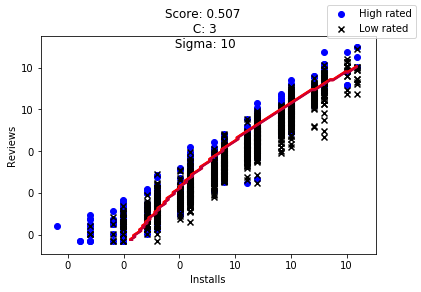

Score con los ejemplos de testing: 0.5069444444444445


In [61]:
import time
feature1 = "Installs"
feature2 = "Reviews"
feature3 = "Price"
NUM_TRIES = 1
X, y = load_Data(data, "High_Rated", [feature1, feature2])
#X, y = load_csv_svm("data/googleplaystore.csv", [feature1, feature2])
#print(y)
X, mu, sigma = Normalization.n_data_matrix(X)
X, y, trainX, trainY, validationX, validationY, testingX, testingY = divide_rate_groups(X, y)

max_score = float("-inf")
best_svm = None
print(sigma)
seed = np.random.seed(int(time.time()))
for i in range(NUM_TRIES):
    #THIS IS GIVING THE SAME RESULT, ALWAYS (MAYBE SELECT C AND SIGMA RANDOMLY)
    
    #sigma = float(np.random.random_sample())
    #print(sigma)
    current_svm, C, s = eleccion_parametros_C_y_Sigma(trainX, trainY, validationX, validationY, mu, sigma)
    current_score = true_score(testingX, testingY, current_svm)
    draw_decisition_boundary(testingX, testingY, current_svm, current_score, mu, sigma, C, s)
    print("Score con los ejemplos de testing: " + str(current_score))
    if current_score > max_score:
        max_score = current_score
        best_svm = current_svm

In [64]:
while True:
    user_values = np.array(list(map(float, input("Gimme stats: ").split())), dtype=float) # (features, )
    if user_values.size == 0:
        break
    user_values = np.reshape(user_values, (np.shape(user_values)[0], 1))
    user_values = np.transpose(user_values)
    user_values = Normalization.n(user_values, mu, sigma) #normalization of user values
    sol = best_svm.predict(user_values)
    print("Is your app high rated?: " + str(sol[0] == 1.0) + "\n")

Gimme stats: 3 1
Is your app high rated?: False

Gimme stats: 6 3
Is your app high rated?: False

Gimme stats: 1 0
Is your app high rated?: True

Gimme stats: 0 0
Is your app high rated?: True

Gimme stats: 10 6
Is your app high rated?: False

Gimme stats: 10 10
Is your app high rated?: True

Gimme stats: 3 2.5
Is your app high rated?: True

Gimme stats: 3 0
Is your app high rated?: False

Gimme stats: 3 1
Is your app high rated?: False

Gimme stats: 3 2
Is your app high rated?: True

Gimme stats: 3 1.5
Is your app high rated?: True

Gimme stats: 3 1.25
Is your app high rated?: True

Gimme stats: 3 1.125
Is your app high rated?: False

Gimme stats: 


In [ ]:
5532746823069403
5413758723828513